In [1]:
using CSV
using DataFrames
using Flux
using HypothesisTests
import JSON
using LinearAlgebra
using MLUtils
using Plots
using StatsBase
using StatsPlots
using Tables

using BSON: @save
using BSON: @load

include("../helpers.jl")
include("../stats.jl")

updatescoresdict! (generic function with 1 method)

In [2]:
train_new_model = true

true

## Edit before running on new data

In [3]:
x_columns_to_drop = []
y_columns_to_drop = []
target_directory = "../data/full_opt_15KeV/"

"../data/full_opt_15KeV/"

## Getting data together

In [4]:
# get data
x_df = DataFrame(
    DVAR1=Float32[],
    DVAR2=Float32[],
    DVAR3=Float32[],
    DVAR4=Float32[],
    DVAR5=Float32[],
    DVAR6=Float32[],
    DVAR7=Float32[],
    DVAR8=Float32[],
    DVAR9=Float32[],
    DVAR10=Float32[],
    DVAR11=Float32[],
    DVAR12=Float32[],
    DVAR13=Float32[],
    DVAR14=Float32[]
)
y_df = DataFrame(
    OBJ1=Float32[],
    OBJ2=Float32[],
    OBJ3=Float32[],
    OBJ4=Float32[],
    OBJ5=Float32[],
    OBJ6=Float32[]
)

x_df, y_df = readjsonsfromdirectory(target_directory, x_df, y_df);

## Data preprocessing

In [5]:
# drop OBJ6
y_df = select!(y_df, Not(["OBJ6"]))

,OBJ1,OBJ2,OBJ3,OBJ4,OBJ5
,Float32,Float32,Float32,Float32,Float32
1,91.0,0.0624,99.34,0.07639,0.07035
2,92.69,0.0579,110.26,0.07544,0.03639
3,70.87,0.0649,80.55,0.07192,0.04194
4,16.85,0.0756,183.99,0.01274,0.01483
5,66.16,0.0674,56.7,0.06682,0.03004
6,77.58,0.0754,118.34,0.0984,0.07412
7,65.54,0.0664,192.13,0.04426,0.02476
8,48.15,0.0745,65.99,0.07916,0.0508
9,52.59,0.0737,152.51,0.03226,0.03045


In [6]:
x_df = decorrelatedvars(x_df);
x_df, _ = minmaxscaledf(x_df);
y_df, y_scalers = minmaxscaledf(y_df);

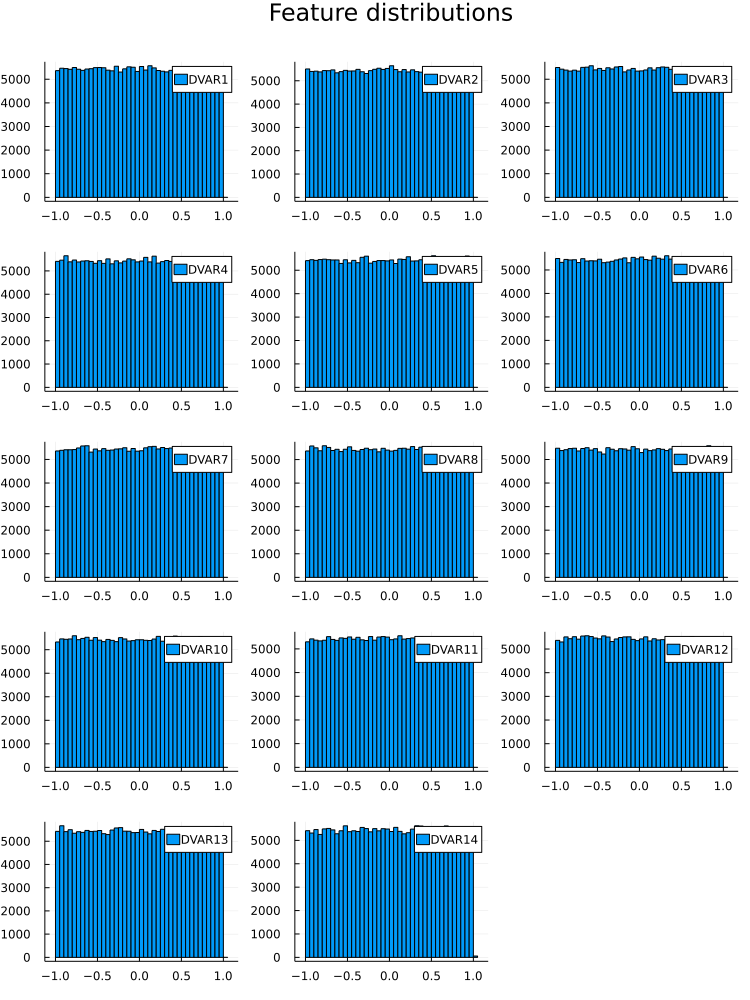

In [7]:
# plot features
l = @layout [grid(5, 3)]

subplots = []
for i in 1:14
    hist = histogram(x_df[:, "DVAR$i"], label="DVAR$i", bins=40)
    push!(subplots, hist)
end

plot(subplots..., layout=l, size=(750, 1000), plot_title="Feature distributions")

In [8]:
x_train_df, x_test_df, y_train_df, y_test_df = traintestsplit(x_df, y_df; read_in=true, path="../indexes/")

x_train = Float64.(Matrix(x_train_df));
x_test = Float64.(Matrix(x_test_df));
y_train = Float64.(Matrix(y_train_df));
y_test = Float64.(Matrix(y_test_df));

- Using preexisting train and test sets


In [9]:
# get dimensions
x_dimension = size(x_train)[2];
y_dimension = size(y_train)[2];

## Building and training the neural net

In [10]:
# build the model
function neuralnetwork()
    Chain(
        Dense(x_dimension, 100, x->σ.(x)),
        (Dense(100, 100, x->σ.(x)) for _ in 1:5)...,
        Dense(100, y_dimension)
    )
end

neuralnetwork (generic function with 1 method)

In [11]:
# organizing data into batches
batch_size = 1024
data_loader = Flux.Data.DataLoader((x_train', y_train'), batchsize=batch_size, shuffle=true);

In [12]:
# training, otherwise loading
if train_new_model
    m = neuralnetwork()
    optimizer = ADAM()
    loss(x, y) = Flux.mse(m(x), y)

    # training
    n_epochs = 2500
    training_losses = Float32[]
    epochs = Int32[]
    training_times = Float32[]

    for epoch in 1:n_epochs
        print("epoch $epoch,")
        start_time = time()
        Flux.train!(loss, Flux.params(m), data_loader, optimizer)
        end_time = time()
        push!(epochs, epoch)
        l = 0.
        for d in data_loader
            l += loss(d...)
        end
        println(" loss=$l")
        push!(training_losses, l)
        push!(training_times, Float32(end_time - start_time))
    end
    
    # @save "trained_nn.bson" m
    # CSV.write("train_indexes.csv",  Tables.table(train_indexes), writeheader=false)
    # CSV.write("test_indexes.csv", Tables.table(test_indexes), writeheader=false)
else
    @load "trained_nn.bson" m
end

epoch 1, loss=15.531093729468239
epoch 2, loss=5.896415183558503
epoch 3, loss=5.085593788998471
epoch 4, loss=3.0776123343484674
epoch 5, loss=2.499929079349425
epoch 6, loss=1.932254493794283
epoch 7, loss=1.6652583401952736
epoch 8, loss=1.5893542268456984
epoch 9, loss=1.4953013844587975
epoch 10, loss=1.4888470479765934
epoch 11, loss=1.4226562895997164
epoch 12, loss=1.382730951055047
epoch 13, loss=1.37649303389393
epoch 14, loss=1.3417436081008918
epoch 15, loss=1.3224037830766442
epoch 16, loss=1.2951689863710183
epoch 17, loss=1.263278330270005
epoch 18, loss=1.2347432989423306
epoch 19, loss=1.206625634285371
epoch 20, loss=1.190279441792562
epoch 21, loss=1.1667838290190253
epoch 22, loss=1.1597046709278747
epoch 23, loss=1.125477759850481
epoch 24, loss=1.1592602282287519
epoch 25, loss=1.1092061217574094
epoch 26, loss=1.1024966910433673
epoch 27, loss=1.10176330724566
epoch 28, loss=1.0801343447420062
epoch 29, loss=1.039163870072956
epoch 30, loss=1.0459796533012367
epo

epoch 239, loss=0.7625095029627361
epoch 240, loss=0.7450105688328844
epoch 241, loss=0.7687450430911541
epoch 242, loss=0.7541743090349847
epoch 243, loss=0.740430597324706
epoch 244, loss=0.7397690065694591
epoch 245, loss=0.7390899616057446
epoch 246, loss=0.746287371129439
epoch 247, loss=0.7361631696810736
epoch 248, loss=0.7393891266221435
epoch 249, loss=0.7416139712311187
epoch 250, loss=0.7894924800565735
epoch 251, loss=0.7441277030563311
epoch 252, loss=0.7584923814203957
epoch 253, loss=0.7637585663934104
epoch 254, loss=0.7450117535156844
epoch 255, loss=0.7374259530519689
epoch 256, loss=0.7427454515932616
epoch 257, loss=0.7576146994343961
epoch 258, loss=0.7791457049661463
epoch 259, loss=0.7568968288349063
epoch 260, loss=0.7392759689587856
epoch 261, loss=0.732816478992023
epoch 262, loss=0.7400640487238686
epoch 263, loss=0.7807450557607799
epoch 264, loss=0.7334694614014974
epoch 265, loss=0.7591695360998226
epoch 266, loss=0.7385149128199294
epoch 267, loss=0.77170

epoch 473, loss=0.6983302870119289
epoch 474, loss=0.7314706967415782
epoch 475, loss=0.7066250377729562
epoch 476, loss=0.7046772530833804
epoch 477, loss=0.6980566476866565
epoch 478, loss=0.7071406767182982
epoch 479, loss=0.7267329128529627
epoch 480, loss=0.7007412575191974
epoch 481, loss=0.7039330444182906
epoch 482, loss=0.6929401312611839
epoch 483, loss=0.6925262003771459
epoch 484, loss=0.7005551197152459
epoch 485, loss=0.7070839394150211
epoch 486, loss=0.700696155001433
epoch 487, loss=0.6973800067633384
epoch 488, loss=0.6946671003975068
epoch 489, loss=0.7039513510285352
epoch 490, loss=0.6989321515475847
epoch 491, loss=0.6929539634375985
epoch 492, loss=0.6953604609933172
epoch 493, loss=0.6974549988525912
epoch 494, loss=0.7061645412541369
epoch 495, loss=0.695957833509973
epoch 496, loss=0.6985110209477455
epoch 497, loss=0.722503407539418
epoch 498, loss=0.701233291556897
epoch 499, loss=0.693522592517907
epoch 500, loss=0.7079094672018625
epoch 501, loss=0.7034900

epoch 707, loss=0.6735875971198348
epoch 708, loss=0.6858942978470071
epoch 709, loss=0.6720571705586716
epoch 710, loss=0.6789527059921066
epoch 711, loss=0.6739089857348763
epoch 712, loss=0.6753742875296965
epoch 713, loss=0.6728942272749701
epoch 714, loss=0.6769069320269503
epoch 715, loss=0.6740826460390837
epoch 716, loss=0.6681343798935696
epoch 717, loss=0.6708782262269146
epoch 718, loss=0.6751717074361757
epoch 719, loss=0.6717930415798139
epoch 720, loss=0.6698941487121257
epoch 721, loss=0.6725311762015073
epoch 722, loss=0.672028121928983
epoch 723, loss=0.6687813165175166
epoch 724, loss=0.6749747747919456
epoch 725, loss=0.6765052923763492
epoch 726, loss=0.6729154222635744
epoch 727, loss=0.6702700435535437
epoch 728, loss=0.6706966684676956
epoch 729, loss=0.6735161040956216
epoch 730, loss=0.6767877767115841
epoch 731, loss=0.6748191181407801
epoch 732, loss=0.6819272009106514
epoch 733, loss=0.6732504449225867
epoch 734, loss=0.6725097186420782
epoch 735, loss=0.674

epoch 941, loss=0.6565844719112627
epoch 942, loss=0.6553885616547973
epoch 943, loss=0.6540570322574517
epoch 944, loss=0.6546842133361835
epoch 945, loss=0.6530360428828443
epoch 946, loss=0.6506004201031533
epoch 947, loss=0.662092597795123
epoch 948, loss=0.6491827518007407
epoch 949, loss=0.6513822294811096
epoch 950, loss=0.6757824538724553
epoch 951, loss=0.6539244538176355
epoch 952, loss=0.650288047676174
epoch 953, loss=0.650115213191893
epoch 954, loss=0.6545593771107038
epoch 955, loss=0.6488699157858567
epoch 956, loss=0.668234564204836
epoch 957, loss=0.6598567160636066
epoch 958, loss=0.6644710291418344
epoch 959, loss=0.648263679322774
epoch 960, loss=0.6517735464901562
epoch 961, loss=0.6549165640829723
epoch 962, loss=0.6534292788755077
epoch 963, loss=0.6666799651371287
epoch 964, loss=0.650834961017519
epoch 965, loss=0.653197439464551
epoch 966, loss=0.6504111898982979
epoch 967, loss=0.646979833433793
epoch 968, loss=0.6538812123536001
epoch 969, loss=0.6684273841

epoch 1171, loss=0.6333618034973771
epoch 1172, loss=0.6381273910114262
epoch 1173, loss=0.6380804839792139
epoch 1174, loss=0.6375362478063399
epoch 1175, loss=0.6328623348409337
epoch 1176, loss=0.6468898646124036
epoch 1177, loss=0.641028135269101
epoch 1178, loss=0.6362561303995499
epoch 1179, loss=0.6404156077294126
epoch 1180, loss=0.6354257266562379
epoch 1181, loss=0.6378514410978056
epoch 1182, loss=0.6366785702496114
epoch 1183, loss=0.6353548531806965
epoch 1184, loss=0.6332698798206043
epoch 1185, loss=0.6346572608852838
epoch 1186, loss=0.6502300007168238
epoch 1187, loss=0.6390437144708215
epoch 1188, loss=0.6342285530868212
epoch 1189, loss=0.6413861905832712
epoch 1190, loss=0.644955853185377
epoch 1191, loss=0.6361208774665786
epoch 1192, loss=0.63257025261136
epoch 1193, loss=0.6433712257997348
epoch 1194, loss=0.6357755650209825
epoch 1195, loss=0.6349835876503319
epoch 1196, loss=0.6363886378765887
epoch 1197, loss=0.6374641062127626
epoch 1198, loss=0.6363252831922

epoch 1399, loss=0.6224112142614666
epoch 1400, loss=0.6216675908264345
epoch 1401, loss=0.6230067684387349
epoch 1402, loss=0.6244970607831859
epoch 1403, loss=0.624098957689686
epoch 1404, loss=0.6300311526531944
epoch 1405, loss=0.625544454471085
epoch 1406, loss=0.6272287912097833
epoch 1407, loss=0.6305057267266121
epoch 1408, loss=0.6200041270055352
epoch 1409, loss=0.6271907574772118
epoch 1410, loss=0.6204245409502976
epoch 1411, loss=0.6241129224092542
epoch 1412, loss=0.620808399248881
epoch 1413, loss=0.6248273948311119
epoch 1414, loss=0.6235166007112017
epoch 1415, loss=0.621508056975996
epoch 1416, loss=0.6224128605798321
epoch 1417, loss=0.6189211793879861
epoch 1418, loss=0.6181327258488379
epoch 1419, loss=0.6286176407727486
epoch 1420, loss=0.6257034638850077
epoch 1421, loss=0.6258849215329693
epoch 1422, loss=0.6230965824349204
epoch 1423, loss=0.6259672243218599
epoch 1424, loss=0.6224330090948138
epoch 1425, loss=0.6230269745623167
epoch 1426, loss=0.6226428661989

epoch 1627, loss=0.6097945542409552
epoch 1628, loss=0.6092820081290512
epoch 1629, loss=0.6193747713776123
epoch 1630, loss=0.6132296351272921
epoch 1631, loss=0.6137492534358036
epoch 1632, loss=0.6094113009421793
epoch 1633, loss=0.608828613582326
epoch 1634, loss=0.6090142297143648
epoch 1635, loss=0.6120449420611825
epoch 1636, loss=0.6159801046661648
epoch 1637, loss=0.6096630180489305
epoch 1638, loss=0.6111479043080038
epoch 1639, loss=0.6198019850848694
epoch 1640, loss=0.6129786796291209
epoch 1641, loss=0.6085345281349374
epoch 1642, loss=0.6181202234691996
epoch 1643, loss=0.6102306430466916
epoch 1644, loss=0.608281677996459
epoch 1645, loss=0.6132711914932649
epoch 1646, loss=0.6161215334627302
epoch 1647, loss=0.6139900795885939
epoch 1648, loss=0.6109206473691092
epoch 1649, loss=0.6100994347236206
epoch 1650, loss=0.6300989028002256
epoch 1651, loss=0.606628082181247
epoch 1652, loss=0.6076207656435609
epoch 1653, loss=0.6111126200760273
epoch 1654, loss=0.608976158841

epoch 1855, loss=0.5970101584748732
epoch 1856, loss=0.5946743172373362
epoch 1857, loss=0.5967965146514023
epoch 1858, loss=0.5988623634471347
epoch 1859, loss=0.5942596294647003
epoch 1860, loss=0.5932271296616237
epoch 1861, loss=0.5976412200826775
epoch 1862, loss=0.5975088395161063
epoch 1863, loss=0.5919028651105818
epoch 1864, loss=0.5978471602445047
epoch 1865, loss=0.5912940579001532
epoch 1866, loss=0.5983414663357751
epoch 1867, loss=0.5924626819779796
epoch 1868, loss=0.5994108376780813
epoch 1869, loss=0.5937619604396677
epoch 1870, loss=0.6020109244532996
epoch 1871, loss=0.6027339549335142
epoch 1872, loss=0.5959657627140781
epoch 1873, loss=0.5959623347936038
epoch 1874, loss=0.598053800985072
epoch 1875, loss=0.5931425419776211
epoch 1876, loss=0.5927077459392739
epoch 1877, loss=0.5980693193215982
epoch 1878, loss=0.5964778401956619
epoch 1879, loss=0.5943345738238288
epoch 1880, loss=0.593684332712378
epoch 1881, loss=0.5984455654636308
epoch 1882, loss=0.59546065767

epoch 2083, loss=0.5843453524041945
epoch 2084, loss=0.5791201357634626
epoch 2085, loss=0.5803752168954412
epoch 2086, loss=0.5837692495606513
epoch 2087, loss=0.581236315001469
epoch 2088, loss=0.5842081486064682
epoch 2089, loss=0.5823366388094765
epoch 2090, loss=0.5790697116054753
epoch 2091, loss=0.5834231410413618
epoch 2092, loss=0.5774371737112893
epoch 2093, loss=0.5849720498061615
epoch 2094, loss=0.5799484038476008
epoch 2095, loss=0.5787733988776839
epoch 2096, loss=0.5851775095170066
epoch 2097, loss=0.5788608977772356
epoch 2098, loss=0.5782604029591843
epoch 2099, loss=0.58350623363126
epoch 2100, loss=0.5857061229274801
epoch 2101, loss=0.578572284533344
epoch 2102, loss=0.5835774707922938
epoch 2103, loss=0.5872781610517279
epoch 2104, loss=0.5801554416510601
epoch 2105, loss=0.5826932923787896
epoch 2106, loss=0.5797326732800674
epoch 2107, loss=0.5842194850556603
epoch 2108, loss=0.5802392212445557
epoch 2109, loss=0.5884504283973788
epoch 2110, loss=0.5856784179720

epoch 2311, loss=0.5647953525574325
epoch 2312, loss=0.5826802465900885
epoch 2313, loss=0.5697752031355301
epoch 2314, loss=0.5689550356215118
epoch 2315, loss=0.5639333927217403
epoch 2316, loss=0.568727431445194
epoch 2317, loss=0.5703366940055355
epoch 2318, loss=0.5692347895731777
epoch 2319, loss=0.5685948871528652
epoch 2320, loss=0.5678432821406675
epoch 2321, loss=0.565071549466809
epoch 2322, loss=0.5663498914131221
epoch 2323, loss=0.5652308731656827
epoch 2324, loss=0.5626909500172628
epoch 2325, loss=0.5672872934914581
epoch 2326, loss=0.5641301721622545
epoch 2327, loss=0.5643819111571804
epoch 2328, loss=0.5704423520812492
epoch 2329, loss=0.5754128021576859
epoch 2330, loss=0.5640666076419234
epoch 2331, loss=0.571883806368017
epoch 2332, loss=0.5773082006432622
epoch 2333, loss=0.5616675980645404
epoch 2334, loss=0.5701893317417434
epoch 2335, loss=0.5635014705763158
epoch 2336, loss=0.5669188342138127
epoch 2337, loss=0.5639511728498998
epoch 2338, loss=0.560921606074

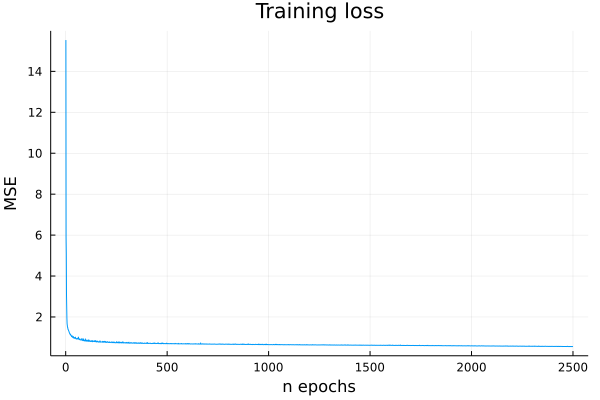

In [13]:
# plot training history
plot(epochs, training_losses; title="Training loss", xlabel="n epochs", ylabel="MSE", legend=false)

## Model evaluation

In [14]:
# rsquared
function r2score(yvec, ŷvec)
    ymean = mean(yvec)
    numerator = sum((y - ŷ)^2 for (y, ŷ) in zip(yvec, ŷvec))
    denominator = sum((y - ymean)^2 for y in yvec)
    1 - numerator / denominator
end
    
function r2score_multidim(ys, ŷs, multioutput::String="uniformaverage")
    d = size(ys, 2)
    r2score_rawvalues = [r2score(ys[:, i], ŷs[:, i]) for i in 1:d]
    if multioutput == "rawvalues"
        return r2score_rawvalues
    elseif multioutput == "uniformaverage"
        return mean(r2score_rawvalues)
    else
        error("multioutput must be one of \"rawvalues\" or \"uniformaverage\"")
    end
end

r2score_multidim (generic function with 2 methods)

In [15]:
r2_train = r2score_multidim(y_train, m(x_train')')
r2_test = r2score_multidim(y_test, m(x_test')')
println("r2 on training set: $r2_train")
println("r2 on test set: $r2_test")

r2 on training set: 0.950595274092708
r2 on test set: 0.938304829206088


In [16]:
# adjusted rsquared
function adjustedr2score(yvec, ŷvec, p::Int)
    M = size(yvec, 1)
    return 1 - (1 - r2score(yvec, ŷvec)) * (M - 1) / (M - p - 1)
end

function adjustedr2score_multidim(ys, ŷs, p::Int, multioutput::String="uniformaverage")
    d = size(ys, 2)
    adjustedr2score_rawvalues = [adjustedr2score(ys[:, i], ŷs[:, i], p) for i in 1:d]
    if multioutput == "rawvalues"
        return adjustedr2score_rawvalues
    elseif multioutput == "uniformaverage"
        return mean(adjustedr2score_rawvalues)
    else
        error("multioutput must be one of \"rawvalues\" or \"uniformaverage\"")
    end
end

adjustedr2score_multidim (generic function with 2 methods)

In [17]:
adjustedr2_train = adjustedr2score_multidim(y_train, m(x_train')', size(x_train, 2))
adjustedr2_test = adjustedr2score_multidim(y_test, m(x_test')', size(x_test, 2))
println("adjustedr2 on training set: $adjustedr2_train")
println("adjustedr2 on test set: $adjustedr2_test")

adjustedr2 on training set: 0.9505912816764033
adjustedr2 on test set: 0.9382848820364821


In [18]:
mae_train = Flux.mae(m(x_train')', y_train)
mae_test = Flux.mae(m(x_test')', y_test)
println("mae on training set: $mae_train")
println("mae on test set: $mae_test")

mae on training set: 0.03563286592931146
mae on test set: 0.03923249517478445


In [19]:
# mae for each response
y_train_preds = m(x_train')'
y_test_preds = m(x_test')'

for i in 1:y_dimension
    mae_train_by_dim = Flux.mae(y_train_preds[:,i], y_train[:, i])
    mae_test_by_dim = Flux.mae(y_test_preds[:, i], y_test[:, i])
    println("mae on training set for OBJ$i: $mae_train_by_dim")
    println("mae on test set for OBJ$i: $mae_test_by_dim")
end

mae on training set for OBJ1: 0.016676459400518248
mae on test set for OBJ1: 0.018771101975187273
mae on training set for OBJ2: 0.07123074761871236
mae on test set for OBJ2: 0.07620323487169538
mae on training set for OBJ3: 0.00948341296734547
mae on test set for OBJ3: 0.00989774295308785
mae on training set for OBJ4: 0.0061164524054741366
mae on test set for OBJ4: 0.006295273065687017
mae on training set for OBJ5: 0.07465725725450709
mae on test set for OBJ5: 0.08499512300826469


In [20]:
# MAPEs
function mape(preds, trues)
    return Statistics.mean((broadcast(abs, preds-trues) ./ broadcast(abs, trues)))
end

mape (generic function with 2 methods)

In [21]:
y_scalers

Dict{String, MinMaxScaler} with 5 entries:
  "OBJ4" => MinMaxScaler(0.00582, 1.34901)
  "OBJ2" => MinMaxScaler(0.0542, 0.087)
  "OBJ3" => MinMaxScaler(35.05, 386.37)
  "OBJ5" => MinMaxScaler(0.00731, 0.10398)
  "OBJ1" => MinMaxScaler(1.53, 99.5)

In [22]:
# mape for each response
for i in 1:y_dimension
    temp_train_preds_normalized = y_train_preds[:, i]
    temp_train_trues_normalized = y_train[:, i]
    
    temp_test_preds_normalized = y_test_preds[:, i]
    temp_test_trues_normalized = y_test[:, i]
    
    # unnormalize
    y_scaler = y_scalers["OBJ$i"]
    
    temp_train_preds_original = inverse_transform(y_scaler, temp_train_preds_normalized)
    temp_train_trues_original = inverse_transform(y_scaler, temp_train_trues_normalized)
    temp_test_preds_original = inverse_transform(y_scaler, temp_test_preds_normalized)
    temp_test_trues_original = inverse_transform(y_scaler, temp_test_trues_normalized)
    
    # println("MAPE on training set for OBJ$i: ", mape(temp_train_preds_original, temp_train_trues_original))
    println("MAPE on test set for OBJ$i: ", mape(temp_test_preds_original, temp_test_trues_original))
end

MAPE on test set for OBJ1: 0.01703995360527774
MAPE on test set for OBJ2: 0.0183370359451264
MAPE on test set for OBJ3: 0.015081565641018601
MAPE on test set for OBJ4: 0.080114590880191
MAPE on test set for OBJ5: 0.11818697016669825


## Plotting / results

| Variable    | Name | MAPE: Me | MAPE: Paper |
| --------- | ---- | ---- | ----- |
| OBJ1  | Transmission  | 1.7% | 2.4% |
| OBJ2  | Output energy | 1.8% | 1.9% |
| OBJ3  | RFQ Length    | 1.3% | 2.0% |
| OBJ4  | Longitudinal $\epsilon$ | 4.8% | 8.2% |
| OBJ5  | $\epsilon_x$ | 11.7% | 12.8% | 
| OBJ6  | $\epsilon_y$ | 11.5% | 12.5% |

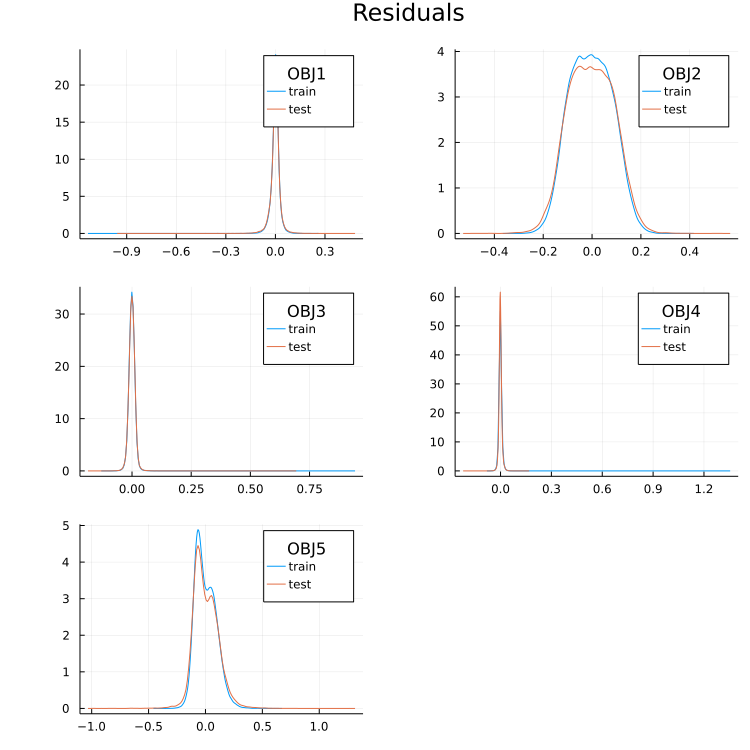

In [23]:
# plotting the residual distribution
l = @layout [grid(3,2)]

y_columns = names(y_df)
residuals_train = y_train - m(x_train')'
residuals_test = y_test - m(x_test')'

subplots = []
for (i, colname) in enumerate(y_columns)
    sp = density(
        residuals_train[:, i];
        xlabel="", ylabel="", label="train", legend=true, legendtitle="    $colname", left_margin = 12Plots.mm
    )
    density!(sp, residuals_test[:, i]; xlabel="", ylabel="", label="test", legend=true)
    push!(subplots, sp)
end

plot(subplots..., layout = l, size=(750, 750), plot_title="Residuals")

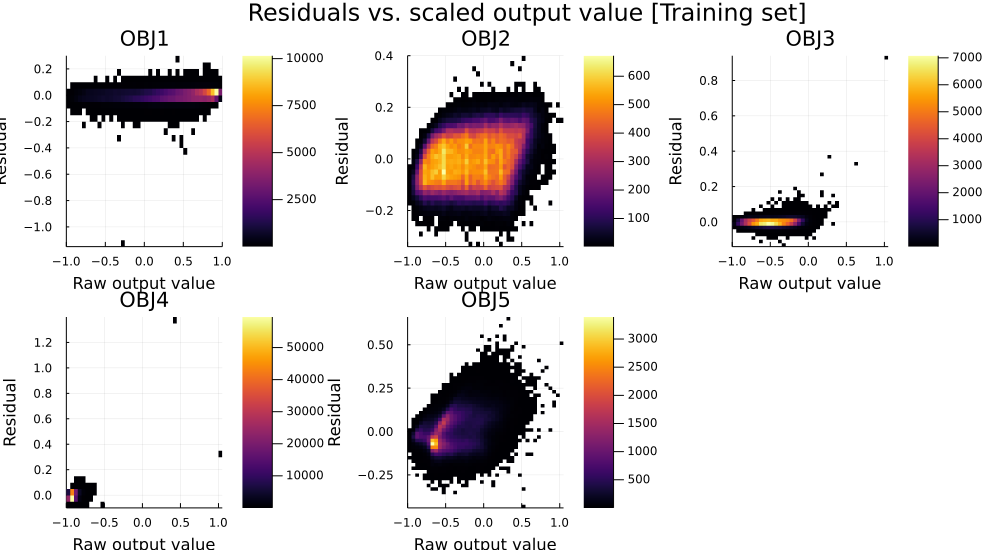

In [24]:
# residuals as a function of scaled objective value
l = @layout [grid(2,3)]

subplots = []
for (i, colname) in enumerate(y_columns)
    sp = histogram2d(
        y_train[:, i], residuals_train[:, i];
        xlabel="Raw output value", ylabel="Residual", label="train", legend=true,
        title="$colname", bins=(60, 60)
    )
    push!(subplots, sp)
end

plot(subplots..., layout = l, size=(1000, 550), plot_title="Residuals vs. scaled output value [Training set]")

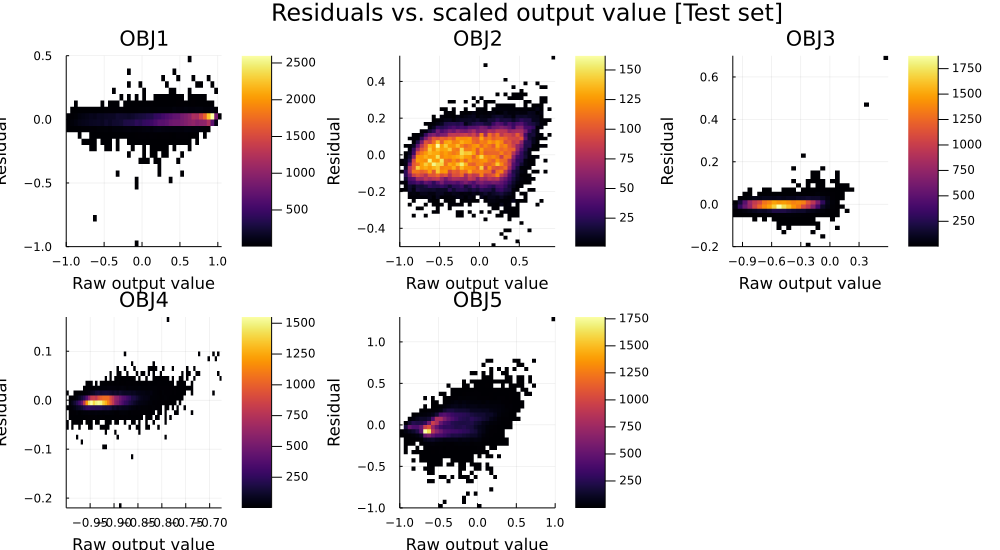

In [25]:
# residuals as a function of scaled objective value, test set
l = @layout [grid(2,3)]

subplots = []
for (i, colname) in enumerate(y_columns)
    sp = histogram2d(
        y_test[:, i], residuals_test[:, i];
        xlabel="Raw output value", ylabel="Residual", label="train", legend=true,
        title="$colname", bins=(60, 60)
    )
    push!(subplots, sp)
end

plot(subplots..., layout = l, size=(1000, 550), plot_title="Residuals vs. scaled output value [Test set]")